# DLVC WS 2017

Tutorial 9: Stochastic Gradient Descent and Learning Rate Dynamics
==

Load Packages
==

In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

Load Data:
===============

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 100

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

Neural Network:
===============

In [4]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.Layer1 = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 256),
            nn.ReLU())
        self.Layer2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.LogSoftmax())

    def forward(self, x):
        x = self.Layer1(x)
        x = self.Layer2(x)
        return x


net1 = NeuralNet()
net2 = NeuralNet()
net3 = NeuralNet()
net4 = NeuralNet()

if use_gpu:
    net1 = net1.double().cuda()
    net2 = net2.double().cuda()
    net3 = net3.double().cuda()
    net4 = net4.double().cuda()
else:
    net1 = net1.double()
    net2 = net2.double()
    net3 = net3.double()
    net4 = net4.double()

Training with different Optimizer:
===========

In [5]:
def Train(model,optimizer,IP,LB):
    optimizer.zero_grad()
    OP = model(IP)
    loss = criterion(OP, LB)
    loss.backward()
    optimizer.step()

/home/iteradmin/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Epoch 1 ; SGD:  0.126400 ; SGD with momentum:  0.195800 ; Adagrad:  0.721500 ; Adam:  0.910300
At Epoch 2 ; SGD:  0.152000 ; SGD with momentum:  0.323400 ; Adagrad:  0.761000 ; Adam:  0.931600
At Epoch 3 ; SGD:  0.177700 ; SGD with momentum:  0.401700 ; Adagrad:  0.796300 ; Adam:  0.942300
At Epoch 4 ; SGD:  0.202700 ; SGD with momentum:  0.465900 ; Adagrad:  0.814700 ; Adam:  0.949800
At Epoch 5 ; SGD:  0.224200 ; SGD with momentum:  0.525600 ; Adagrad:  0.829900 ; Adam:  0.954700
At Epoch 6 ; SGD:  0.247500 ; SGD with momentum:  0.585900 ; Adagrad:  0.839700 ; Adam:  0.961300
At Epoch 7 ; SGD:  0.269900 ; SGD with momentum:  0.630500 ; Adagrad:  0.847600 ; Adam:  0.963900
At Epoch 8 ; SGD:  0.294400 ; SGD with momentum:  0.668100 ; Adagrad:  0.852800 ; Adam:  0.967400
At Epoch 9 ; SGD:  0.316300 ; SGD with momentum:  0.699300 ; Adagrad:  0.857400 ; Adam:  0.970200
At Epoch 10 ; SGD:  0.335400 ; SGD with momentum:  0.734100 ; Adagrad:  0.860800 ; Adam:  0.970100
Finished Training


Text(0,0.5,u'Testing Accuracy (in log10 scale)')

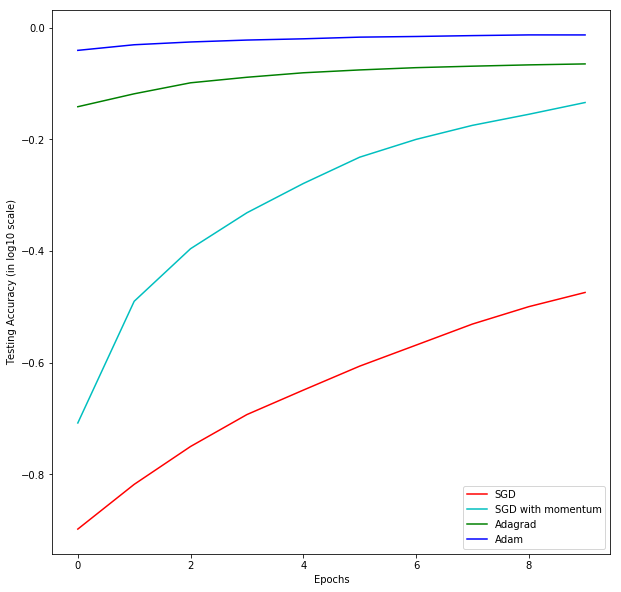

In [6]:
iterations = 10
criterion = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(net1.parameters(), lr=1e-4)
optimizer2 = optim.SGD(net2.parameters(), lr=1e-4, momentum=0.9)
optimizer3 = optim.Adagrad(net3.parameters(), lr=1e-4)
optimizer4 = optim.Adam(net4.parameters(), lr=1e-4)
PlotAcc1 = []
PlotAcc2 = []
PlotAcc3 = []
PlotAcc4 = []

for epoch in range(iterations):  # loop over the dataset multiple times

    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), Variable(labels)
            
        Train(net1,optimizer1,inputs,labels)
        Train(net2,optimizer2,inputs,labels)
        Train(net3,optimizer3,inputs,labels)
        Train(net4,optimizer4,inputs,labels)
        
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), labels
        total += labels.size(0)
        
        outputs = net1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct1 += (predicted == labels).sum()
        
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct2 += (predicted == labels).sum()
        
        outputs = net3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct3 += (predicted == labels).sum()
        
        outputs = net4(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct4 += (predicted == labels).sum()
        
    PlotAcc1.append(math.log10(correct1/float(total)))
    PlotAcc2.append(math.log10(correct2/float(total)))
    PlotAcc3.append(math.log10(correct3/float(total)))
    PlotAcc4.append(math.log10(correct4/float(total)))
    print('At Epoch %d ; SGD:  %f ; SGD with momentum:  %f ; Adagrad:  %f ; Adam:  %f'%((epoch+1),correct1/float(total),correct2/float(total),correct3/float(total),correct4/float(total)))
print('Finished Training')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()        
plt.plot(range(epoch+1),PlotAcc1,'r-',label='SGD')
plt.plot(range(epoch+1),PlotAcc2,'c-',label='SGD with momentum')
plt.plot(range(epoch+1),PlotAcc3,'g-',label='Adagrad')
plt.plot(range(epoch+1),PlotAcc4,'b-',label='Adam')        
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy (in log10 scale)')  

Neural Net:
===

In [17]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.Layer1 = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 256),
            nn.ReLU())
        self.Layer2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.LogSoftmax())

    def forward(self, x):
        x = self.Layer1(x)
        x = self.Layer2(x)
        return x


net1 = NeuralNet()
net2 = NeuralNet()

if use_gpu:
    net1 = net1.double().cuda()
    net2 = net2.double().cuda()
else:
    net1 = net1.double()
    net2 = net2.double()

Training with different Learning Rates:
===========

At Epoch 1 ; SGD:  0.961500 ; SGD with lr decay:  0.961800
At Epoch 2 ; SGD:  0.971600 ; SGD with lr decay:  0.973000
At Epoch 3 ; SGD:  0.974500 ; SGD with lr decay:  0.978300
At Epoch 4 ; SGD:  0.979000 ; SGD with lr decay:  0.972200
At Epoch 5 ; SGD:  0.979100 ; SGD with lr decay:  0.976400
At Epoch 6 ; SGD:  0.977300 ; SGD with lr decay:  0.977400
At Epoch 7 ; SGD:  0.982100 ; SGD with lr decay:  0.981100
At Epoch 8 ; SGD:  0.980000 ; SGD with lr decay:  0.982300
At Epoch 9 ; SGD:  0.981300 ; SGD with lr decay:  0.978900
At Epoch 10 ; SGD:  0.978900 ; SGD with lr decay:  0.979200
Learning Rate Changed
At Epoch 11 ; SGD:  0.980100 ; SGD with lr decay:  0.983700
At Epoch 12 ; SGD:  0.980900 ; SGD with lr decay:  0.984300
At Epoch 13 ; SGD:  0.980400 ; SGD with lr decay:  0.985100
At Epoch 14 ; SGD:  0.982700 ; SGD with lr decay:  0.985100
At Epoch 15 ; SGD:  0.973800 ; SGD with lr decay:  0.985400
At Epoch 16 ; SGD:  0.982100 ; SGD with lr decay:  0.985400
At Epoch 17 ; SGD:  0.98170

Text(0,0.5,u'Testing Accuracy')

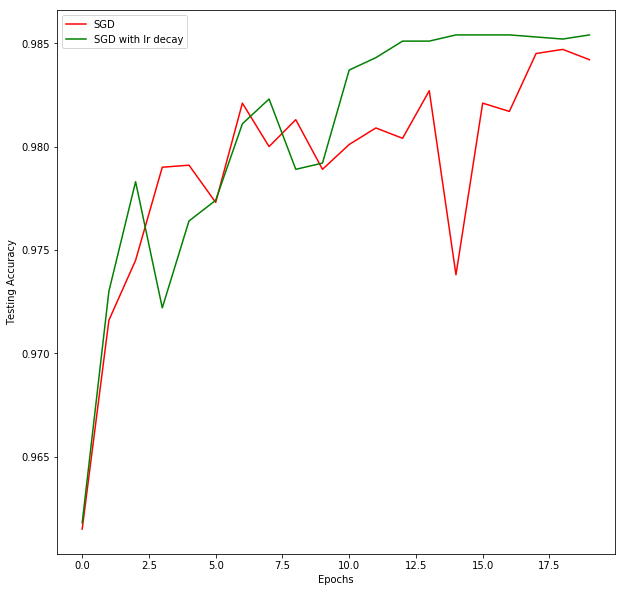

In [18]:
iterations = 20
criterion = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(net1.parameters(), lr=1e-1, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=1e-1, momentum=0.9)
PlotAcc1 = []
PlotAcc2 = []

for epoch in range(iterations):  # loop over the dataset multiple times
    
    correct1 = 0
    correct2 = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), Variable(labels)
            
        Train(net1,optimizer1,inputs,labels)
        Train(net2,optimizer2,inputs,labels)
        
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), labels
        total += labels.size(0)
        
        outputs = net1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct1 += (predicted == labels).sum()
        
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct2 += (predicted == labels).sum()
        
    PlotAcc1.append(correct1/float(total))
    PlotAcc2.append(correct2/float(total))
    print('At Epoch %d ; SGD:  %f ; SGD with lr decay:  %f'%((epoch+1),correct1/float(total),correct2/float(total)))
    if (epoch+1)%10 == 0:
        for param_group in optimizer2.param_groups:
            param_group['lr'] = 1e-3
            print('Learning Rate Changed')
print('Finished Training')
fig = plt.figure()        
plt.plot(range(epoch+1),PlotAcc1,'r-',label='SGD')
plt.plot(range(epoch+1),PlotAcc2,'g-',label='SGD with lr decay')     
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')  